# Use GANs to create art - will you be the next Monet?

In [1]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
from PIL import Image, ImageDraw
import IPython.display as display
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
color = ['#247BA0', '#F6511D', '#7FB800', '#FFB400', '#F25F5C', '#50514F']

## **Brief description of the problem and data**

This project is about I’m Something of a Painter Myself (Use GANs to create art - will you be the next Monet?) which is one of the competition on Kaggle, the data using in this project is a dataset of painting images and photos.

The challenge of this project is to build a generative adversarial networks (GANs) model to learn from painting images and generates 7,000 to 10,000 Monet-style images based on the photos.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

First, let us check the number of files from the dataset.

In [3]:
num_monet_jpg = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/monet_jpg'))
num_monet_tfrec = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/monet_tfrec'))
num_photo_jpg = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/photo_jpg'))
num_photo_tfrec = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/photo_tfrec'))

print('There are ' + str(num_monet_jpg) + ' monet images in the dataset')
print('There are ' + str(num_photo_jpg) + ' photo images in the dataset')
print('There are ' + str(num_monet_tfrec) + ' monet image TFRecordDataset files')
print('There are ' + str(num_photo_tfrec) + ' photo image TFRecordDataset files')

There are 300 monet images in the dataset
There are 7038 photo images in the dataset
There are 5 monet image TFRecordDataset files
There are 20 photo image TFRecordDataset files


Then , we take a look at one of the TFRecordDatasets to see the data structure. There are three keys in the dataset: image, image_name and target

In [5]:
sample_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/monet_tfrec/monet00-60.tfrec')

In [6]:
for raw_record in sample_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001\001\001\000\000\000\000\000\000\000\000\006\007\004\005\003\010\t\002\000\n\001\377\304\000K\020\000\002\001\002\004\003\005\005\004\t\003\001\007\001\t\000\003\004\005\006\023\000\002\007#\0243C\010\022\025Sc\001\"$s\203\02624\223\t\027%D\243\263\303\323\360\021B\343\363!&5ERTd\030\n1QUbrt\264\324\377\304\000\

In the following, we try to inspect the monet images and photo images in the dataset.

In [9]:
# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  example =  tf.io.parse_single_example(example_proto, image_feature_description)
  example_image = tf.image.decode_jpeg(example['image'], channels = 3)
  example_image = (tf.cast(example_image, tf.float32) / 127.5) - 1
  example_image = tf.reshape(example_image, [256, 256, 3])
  return example_image

In [52]:
#Reading one of the monet image datasets
raw_monet_image_dataset_sample = tf.data.TFRecordDataset('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/monet_tfrec/monet00-60.tfrec')
parsed_monet_image_dataset_sample = raw_monet_image_dataset_sample.map(_parse_image_function)

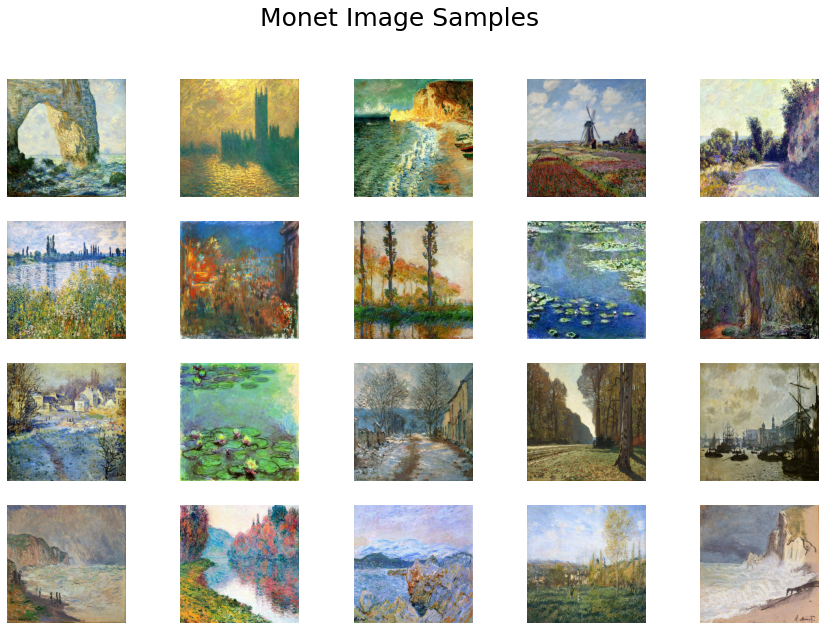

In [57]:
fig, ax = plt.subplots(4, 5, figsize=(15,10))
fig.suptitle('Monet Image Samples', fontsize = 25)
count = 1
monet_ds_iter = iter(parsed_monet_image_dataset_sample.batch(1))
for i in range(20):
    image = next(monet_ds_iter)
    plt.subplot(4, 5, count)
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.axis('off')
    count += 1

In [54]:
#Reading one of the photo image datasets
raw_photo_image_dataset_sample = tf.data.TFRecordDataset('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/photo_tfrec/photo00-352.tfrec')
parsed_photo_image_dataset_sample = raw_photo_image_dataset_sample.map(_parse_image_function)

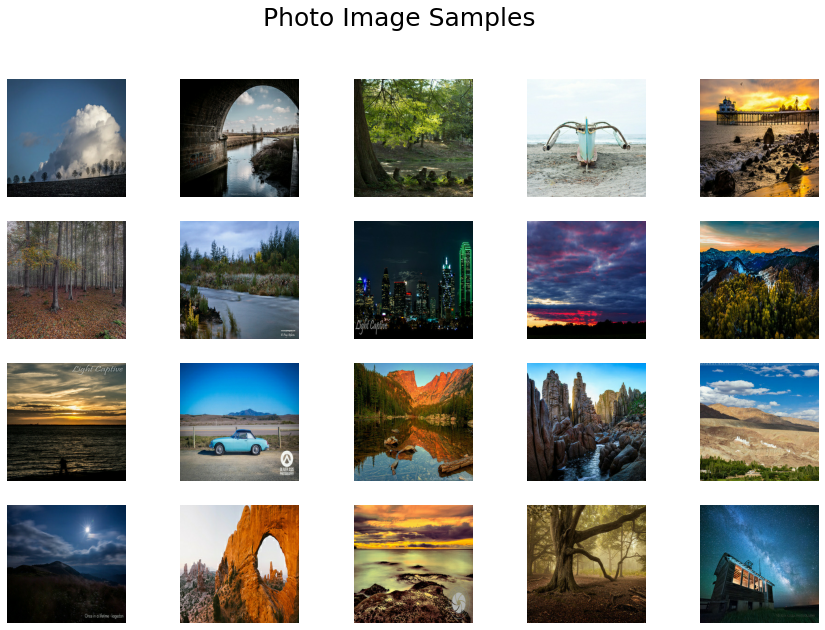

In [56]:
fig, ax = plt.subplots(4, 5, figsize=(15,10))
fig.suptitle('Photo Image Samples', fontsize = 25)
count = 1
photo_ds_iter = iter(parsed_photo_image_dataset_sample.batch(1))
for i in range(20):
    image = next(photo_ds_iter)
    plt.subplot(4, 5, count)
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.axis('off')
    count += 1

In [10]:
#Loading all of the photo and monet image dataset
photo_file_list = tf.io.gfile.glob('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/photo_tfrec/*.tfrec')
monet_file_list = tf.io.gfile.glob('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/monet_tfrec/*.tfrec')
raw_photo_image_dataset = tf.data.TFRecordDataset(photo_file_list)
parsed_photo_image_dataset = raw_photo_image_dataset.map(_parse_image_function)
parsed_photo_image_dataset = parsed_photo_image_dataset.batch(1)
raw_monet_image_dataset = tf.data.TFRecordDataset(monet_file_list)
parsed_monet_image_dataset = raw_monet_image_dataset.map(_parse_image_function)
parsed_monet_image_dataset = parsed_monet_image_dataset.batch(1)

## **Model Architecture**

In this project, I use CycleGAN to finish the job since CycleGAN can solve image-to-image translation problem.

In [27]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)

First, I prepare the blocks for the CycleGAN generators and discriminators. Downsample and upsample will be used in the generator. 

In [28]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


A CycleGAN consists of a generator and a discriminator. The generator and the discriminsator will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real and generated images.

Now, we start to build the generator and the discriminator.

In [29]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [30]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

Then, we start to build the CycleGan model with the gerneator and the discriminator created.

In [31]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet
            fake_y = self.gen_G(real_x, training=True)
            # monet to photo
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (photo to monet to photo): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (monet to photo to monet) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

Finally, we define the loss function, compile the model and start the training.

In [33]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)


# Here we will train the model for 10 epochs.
cycle_gan_model.fit(
    tf.data.Dataset.zip((parsed_photo_image_dataset, parsed_monet_image_dataset)),
    epochs=10,
)

Epoch 1/10
300/300 [==============================] - 281s 732ms/step - G_loss: 5.0783 - F_loss: 5.9071 - D_X_loss: 0.1101 - D_Y_loss: 0.1291
Epoch 2/10
300/300 [==============================] - 219s 730ms/step - G_loss: 4.5976 - F_loss: 5.2418 - D_X_loss: 0.1614 - D_Y_loss: 0.1889
Epoch 3/10
300/300 [==============================] - 219s 729ms/step - G_loss: 4.1746 - F_loss: 4.7924 - D_X_loss: 0.1578 - D_Y_loss: 0.2208
Epoch 4/10
300/300 [==============================] - 219s 728ms/step - G_loss: 4.0005 - F_loss: 4.4893 - D_X_loss: 0.1442 - D_Y_loss: 0.1974
Epoch 5/10
300/300 [==============================] - 218s 728ms/step - G_loss: 3.8910 - F_loss: 4.4087 - D_X_loss: 0.1151 - D_Y_loss: 0.1802
Epoch 6/10
300/300 [==============================] - 218s 727ms/step - G_loss: 3.8792 - F_loss: 4.3282 - D_X_loss: 0.1414 - D_Y_loss: 0.1777
Epoch 7/10
300/300 [==============================] - 218s 727ms/step - G_loss: 3.8605 - F_loss: 4.1116 - D_X_loss: 0.1618 - D_Y_loss: 0.1639
Epoch 

## **Results and Analysis**

We have finished training the model, and now we plot some of the translated images to check out the result. It seems that there are color distortion in the translated monet images and noticeable blurs and mosaics are on the images, but the images are indeed look like monet images.

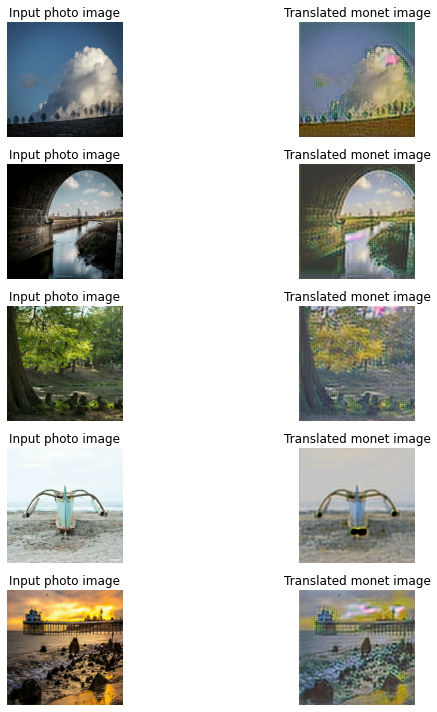

In [58]:
_, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, img in enumerate(parsed_photo_image_dataset.take(5)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input photo image")
    ax[i, 1].set_title("Translated monet image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.tight_layout()
plt.show()

Now, we are going to generate all the monet images based on the photo images provided.

In [50]:
count = 1
for img in parsed_photo_image_dataset:
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save('/content/drive/MyDrive/Colab Notebooks/Use GANs to create art - will you be the next Monet?/submission/{count}.jpg'.format(count=count))
    count += 1

In this competition, submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance). The small MiFID means good result. This submission has a score of 85.18756, and this is not good enough since the top leader has a score of around 35.

I think there are many ways to improve the model, like doing data augmentation, training the model with larger epochs, changing layers and parameters, etc.

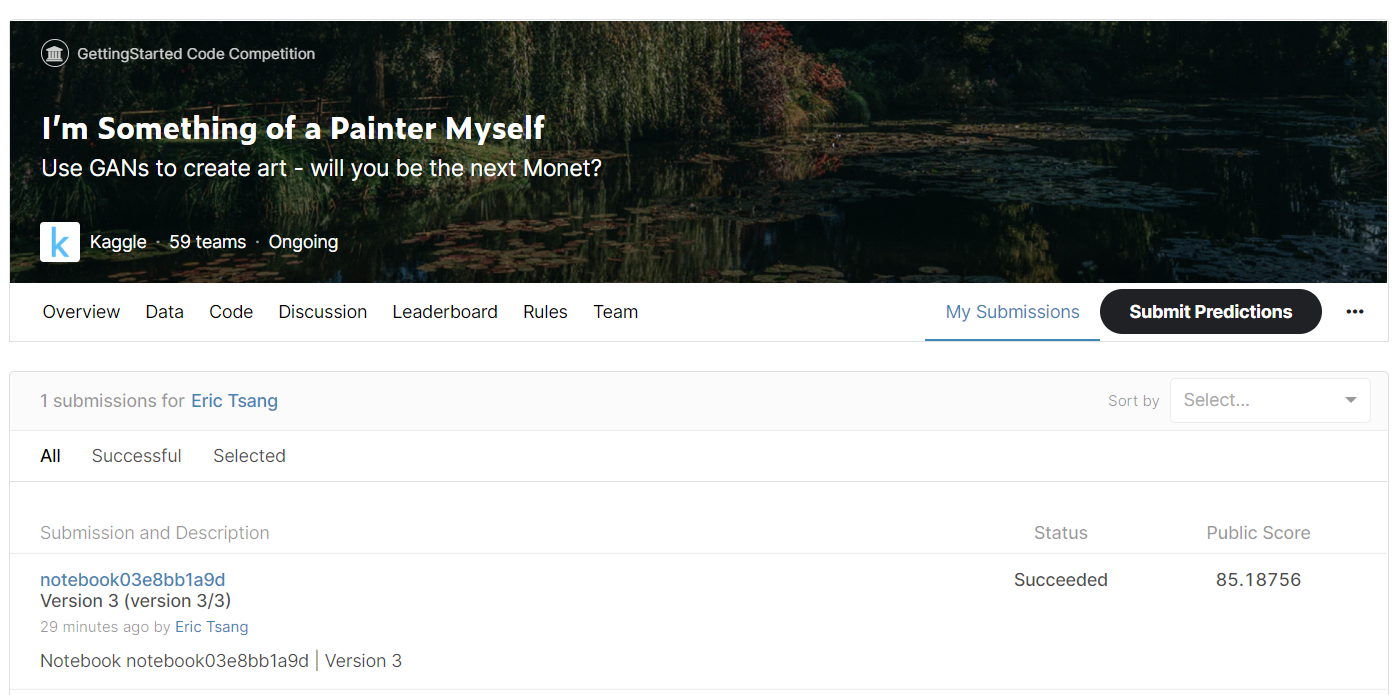

## **Conclusion**

Training a CycleGAN model is not a easy job, it is actually quite tough. There are many ways to fine tune the model, we can keep changing the architecture of the model to see if it can get a better result, but it is really time consuming.

The model created in this project is only a beginner level work, and there are many ways to improve the model, like doing data augmentation, training the model with larger epochs, changing layers and parameters, etc.

Overall, it is quite amazing that technology can let amateur people like me to train a model to create monet art based on real photo image.